In [1]:
import numpy as np
import pandas as pd
# para calculas métricas del modelo
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
# misc
import os
import time
import itertools
import warnings
warnings.filterwarnings("ignore")

# apartado ts
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing, Holt

#from prophet import Prophet

In [6]:
ts = pd.read_csv('../../data/ts_top100_prediction.csv')
ts.head(5)

,date,id,item,sales,income,event
0,2011-01-29,ACCESORIES_1_108_NYC_1,ACCESORIES_1_108,4,64.4784,0
1,2011-01-29,HOME_&_GARDEN_1_027_NYC_1,HOME_&_GARDEN_1_027,4,26.2000,0
2,2011-01-29,HOME_&_GARDEN_1_053_NYC_1,HOME_&_GARDEN_1_053,0,0.0000,0
3,2011-01-29,HOME_&_GARDEN_1_140_NYC_1,HOME_&_GARDEN_1_140,4,75.0000,0
4,2011-01-29,HOME_&_GARDEN_1_177_NYC_1,HOME_&_GARDEN_1_177,0,0.0000,0


In [7]:
ts_income = ts[['date', 'income','item']]

In [8]:
ts_income.head(2)

,date,income,item
0,2011-01-29,64.4784,ACCESORIES_1_108
1,2011-01-29,26.2000,HOME_&_GARDEN_1_027


In [9]:
df_SUPERMARKET_3_586 = ts_income[ts_income['item']=='SUPERMARKET_3_586']

In [10]:
ts_predict = df_SUPERMARKET_3_586.groupby(['date'])['income'].sum().reset_index() #ts=suma de todas las ventas de todas las tiendas agrupado por día

In [11]:
ts_predict.set_index('date', inplace=True)

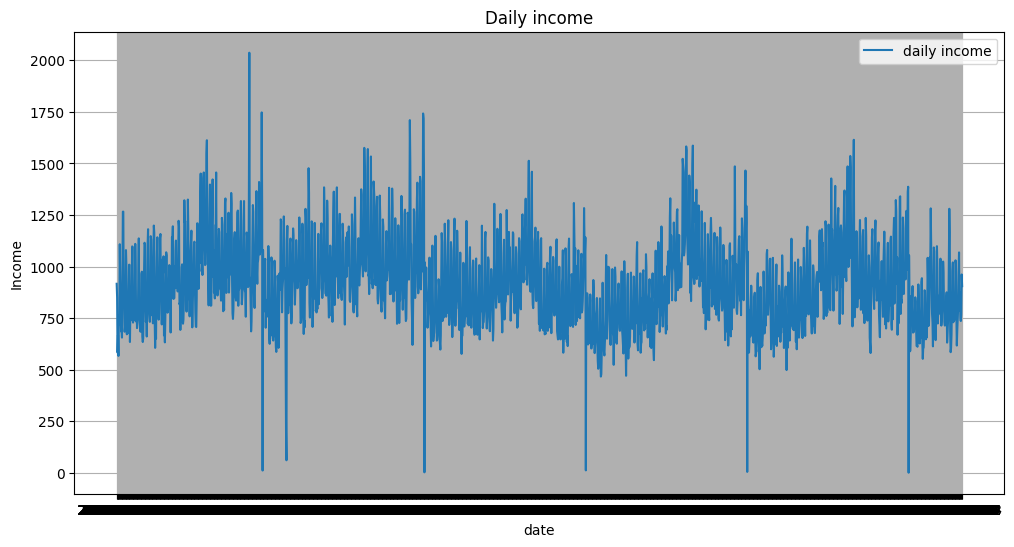

In [13]:
import matplotlib.pyplot as plt

# Graficar la serie temporal
plt.figure(figsize=(12, 6))
plt.plot(ts_predict.index, ts_predict['income'], label='daily income')
plt.xlabel('date')
plt.ylabel('Income')
plt.title('Daily income')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts_predict['income'])
print(f'Estadístico ADF: {result[0]}')
print(f'Valor p: {result[1]}')

Estadístico ADF: -3.8075214875178487
Valor p: 0.002831291037097121


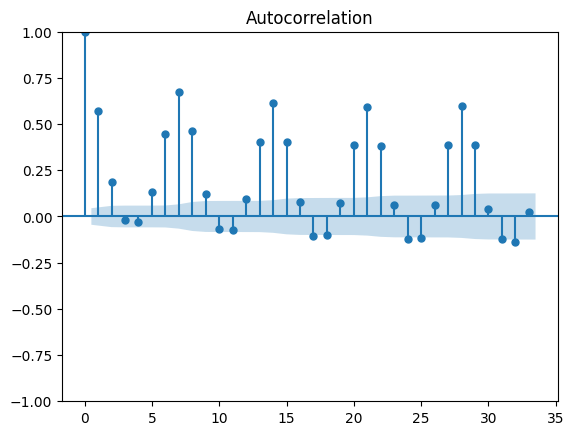

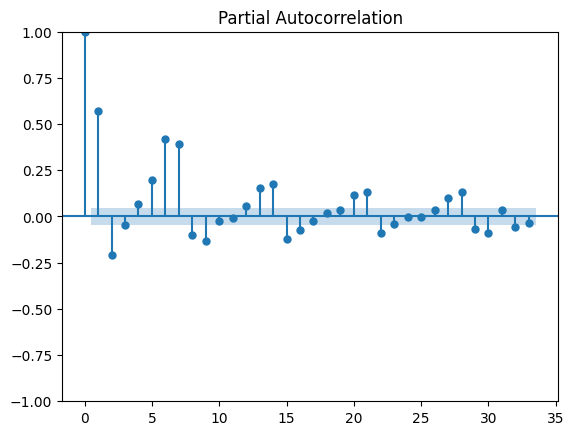

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_predict)
plt.show()

plot_pacf(ts_predict)
plt.show()

In [16]:
df_train = ts_predict[:-30]
df_test = ts_predict[-30:]

In [17]:
df_train

,income
date,
2011-01-29,916.416
2011-01-30,850.704
2011-01-31,582.528
2011-02-01,667.776
2011-02-02,566.544
...,...
2016-03-21,631.008
2016-03-22,675.360
2016-03-23,727.776


In [18]:
pdq = [
    (1, 0, 1), (1, 0, 2),
    (2, 0, 3), (2, 0, 4),
    (2, 0, 5), (2, 0, 1),
    (2, 0, 2), (2, 0, 3),
    (2, 0, 4),

    
    
    # Opciones con d = 1 (por si acaso)
    # (1, 1, 1), (1, 1, 2),
    # (2, 1, 1), (2, 1, 2)

    (1, 1, 1), (1, 1, 2),
    (2, 1, 3), (2, 1, 4),
    (2, 1, 5), (2, 1, 1),
    (2, 1, 2), (2, 1, 3),
    (2, 1, 4), (2, 1, 5)
]

# Probar también con algún P o Q diferente de 0 en la parte estacional
seasonal_pdq = (0, 1, 0, 7) # Actual
#     (1, 1, 0, 7),  # AR estacional
#     (0, 1, 1, 7),  # MA estacional
#     (1, 1, 1, 7)   # AR y MA estacional

In [20]:
RESULTS_DICT = {}

for param in pdq:

    model = sm.tsa.statespace.SARIMAX(
        endog = df_train,
        order = param,
        seasonal_order = seasonal_pdq,
        enforce_stationarity = False,
        enforce_invertibility = False
    )

    model_fitted = model.fit()

    print('ARIMA{}x{}12 - AIC:{}'.format(param, seasonal_pdq, model_fitted.aic))

    RESULTS_DICT[param] = round(model_fitted.aic, 2)

c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 0, 1)x(0, 1, 0, 7)12 - AIC:24388.735482891097
ARIMA(1, 0, 2)x(0, 1, 0, 7)12 - AIC:24377.886531255637


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 3)x(0, 1, 0, 7)12 - AIC:24094.552810549743


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 4)x(0, 1, 0, 7)12 - AIC:24078.23968956957


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 5)x(0, 1, 0, 7)12 - AIC:23919.972524866615
ARIMA(2, 0, 1)x(0, 1, 0, 7)12 - AIC:24390.630038690768


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 2)x(0, 1, 0, 7)12 - AIC:24347.630373611668


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 3)x(0, 1, 0, 7)12 - AIC:24094.552810549743


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 0, 4)x(0, 1, 0, 7)12 - AIC:24078.23968956957


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 1)x(0, 1, 0, 7)12 - AIC:24393.130417460452


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 2)x(0, 1, 0, 7)12 - AIC:24391.999046572593


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 3)x(0, 1, 0, 7)12 - AIC:24363.651715134427


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

ARIMA(2, 1, 4)x(0, 1, 0, 7)12 - AIC:24156.049511365716


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 5)x(0, 1, 0, 7)12 - AIC:24179.0580724499


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 1)x(0, 1, 0, 7)12 - AIC:24385.857296890084


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

ARIMA(2, 1, 2)x(0, 1, 0, 7)12 - AIC:24378.235885335318
ARIMA(2, 1, 3)x(0, 1, 0, 7)12 - AIC:24363.651715134427


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: Val

ARIMA(2, 1, 4)x(0, 1, 0, 7)12 - AIC:24156.049511365716


c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(2, 1, 5)x(0, 1, 0, 7)12 - AIC:24179.0580724499


In [21]:
gsx = list(map(str, list(RESULTS_DICT.keys())))
gsy = list(RESULTS_DICT.values())

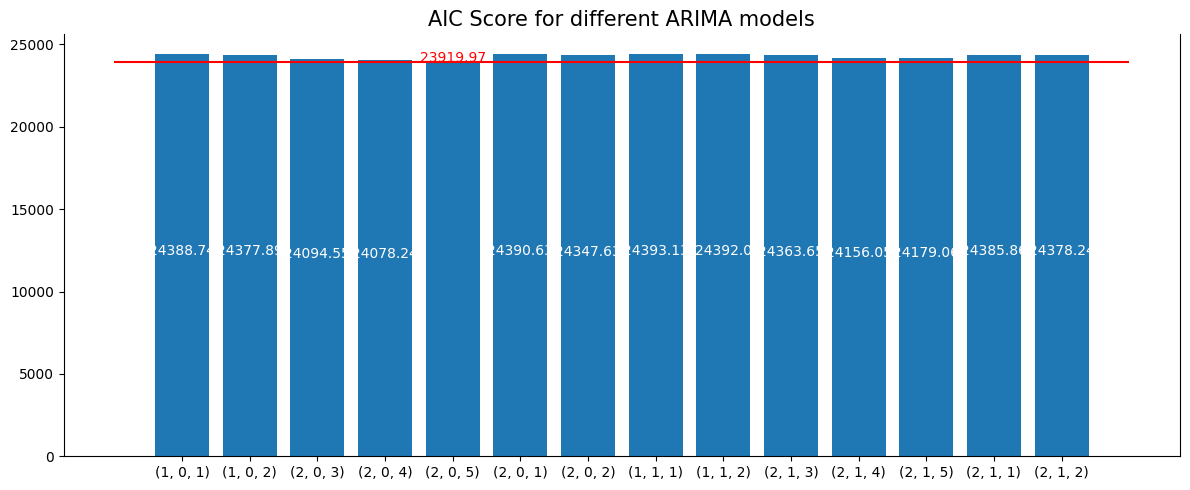

In [22]:
fig = plt.figure(figsize = (12, 5))
ax = fig.add_subplot()

ax.bar(x = gsx, height = gsy)
ax.hlines(y = min(gsy), xmin = -1, xmax = len(gsx), color = "red")

for xtick_, y_ in zip(gsx, gsy):

    s_ = str(round(y_, 2))

    ax.text(
        x = xtick_,
        y = y_/2 if y_ != min(gsy) else y_ + 10,
        s = s_,
        ha = "center",
        color = "red" if y_ == min(gsy) else "white"
    )

ax.spines["top"].set_color("None")

plt.title(label = "AIC Score for different ARIMA models", fontsize = 15)
plt.tight_layout()

In [23]:
RESULTS_DICT

{(1, 0, 1): np.float64(24388.74),
 (1, 0, 2): np.float64(24377.89),
 (2, 0, 3): np.float64(24094.55),
 (2, 0, 4): np.float64(24078.24),
 (2, 0, 5): np.float64(23919.97),
 (2, 0, 1): np.float64(24390.63),
 (2, 0, 2): np.float64(24347.63),
 (1, 1, 1): np.float64(24393.13),
 (1, 1, 2): np.float64(24392.0),
 (2, 1, 3): np.float64(24363.65),
 (2, 1, 4): np.float64(24156.05),
 (2, 1, 5): np.float64(24179.06),
 (2, 1, 1): np.float64(24385.86),
 (2, 1, 2): np.float64(24378.24)}

In [24]:
idx_min_score_aic = np.argmin(list(RESULTS_DICT.values()))
pdq_min_score_aic = list(RESULTS_DICT.keys())[idx_min_score_aic]
min_score_aic = RESULTS_DICT[pdq_min_score_aic]

message = f'''
El score mínimo se alcanza con ARIMA{pdq_min_score_aic}
Con un score AIC de {min_score_aic}.
En la posición {idx_min_score_aic}
'''

print(message)


El score mínimo se alcanza con ARIMA(2, 0, 5)
Con un score AIC de 23919.97.
En la posición 4



In [25]:
best_arima_model = sm.tsa.statespace.SARIMAX(
    endog = df_train,
    order = (2,0,4),
    seasonal_order = seasonal_pdq,
    enforce_stationarity = False,
    enforce_invertibility = False
)

best_arima_model_fitted = best_arima_model.fit()

c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\harol\Nuclio\DS-MARKET-TFM\env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [26]:
print(best_arima_model_fitted.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0262      0.025     41.633      0.000       0.978       1.075
ar.L2         -0.6515      0.019    -34.617      0.000      -0.688      -0.615
ma.L1         -0.8051      0.026    -30.579      0.000      -0.857      -0.754
ma.L2          0.6184      0.026     23.598      0.000       0.567       0.670
ma.L3          0.2248      0.027      8.390      0.000       0.172       0.277
ma.L4          0.1710      0.028      6.042      0.000       0.115       0.226
sigma2      2.583e+04    402.588     64.158      0.000     2.5e+04    2.66e+04


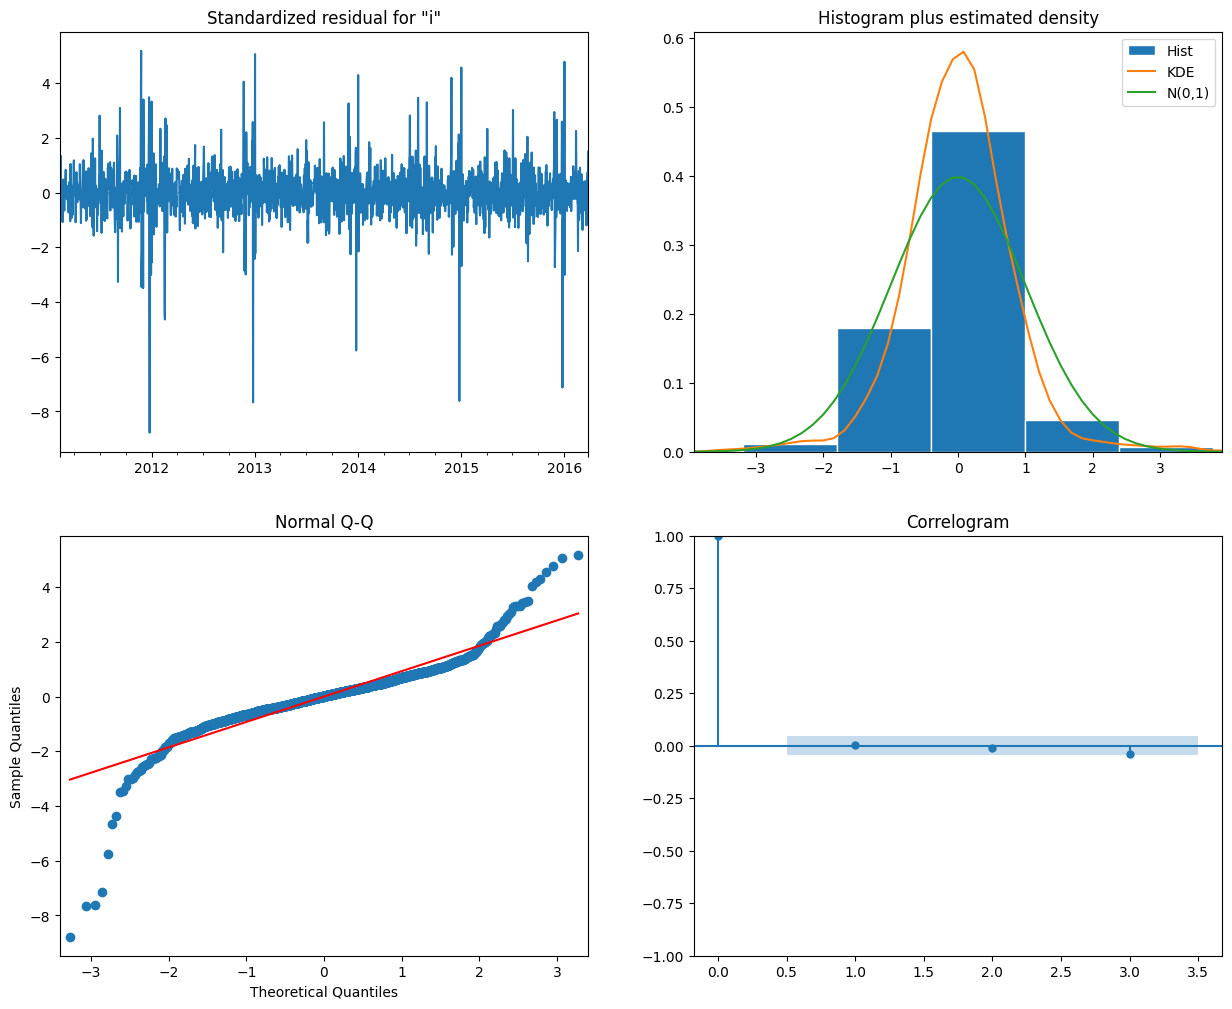

In [27]:
best_arima_model_fitted.plot_diagnostics(figsize = (15, 12), lags = 3);

In [35]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = best_arima_model_fitted.get_forecast(steps = len(df_test))
y_pred_test = pred_uc.predicted_mean

# 1. Calculate MSE
mse = mean_squared_error(df_test['income'], y_pred_test)
print(f'The error MSE is : {mse}')
# 2. Calculate RMSPE
rmspe = np.sqrt(np.mean(((df_test - y_pred_test) / df_test) ** 2)) * 100
print(f'El error RMSPE es: {rmspe:.2f}%')
rmse = np.sqrt(mean_squared_error(df_test['income'], y_pred_test))
print(f'RMSE: {rmse}')

The error MSE is : 11198.050797515045
El error RMSPE es: nan%
RMSE: 105.82084292574429


In [31]:
resultado = {'predicion': y_pred_test.values, 'test':df_test['income']}

In [32]:
pd.DataFrame(resultado)

,predicion,test
date,,
2016-03-26,993.722807,1280.160
2016-03-27,1023.137763,1167.264
2016-03-28,744.808892,683.424
2016-03-29,736.657374,584.640
2016-03-30,716.536340,604.800
2016-03-31,736.783667,669.312
2016-04-01,970.563834,816.480
2016-04-02,980.564742,977.760
2016-04-03,1039.279529,1020.096


In [33]:
ts_predict.reset_index(inplace=True)
ts_predict['date'] = pd.to_datetime(ts_predict['date'])
ts_predict.set_index('date', inplace=True)
#y_pred_test.set_index('date', inplace=True)

Text(0.5, 0.98, 'Lynx Values and ARIMA Forecast')

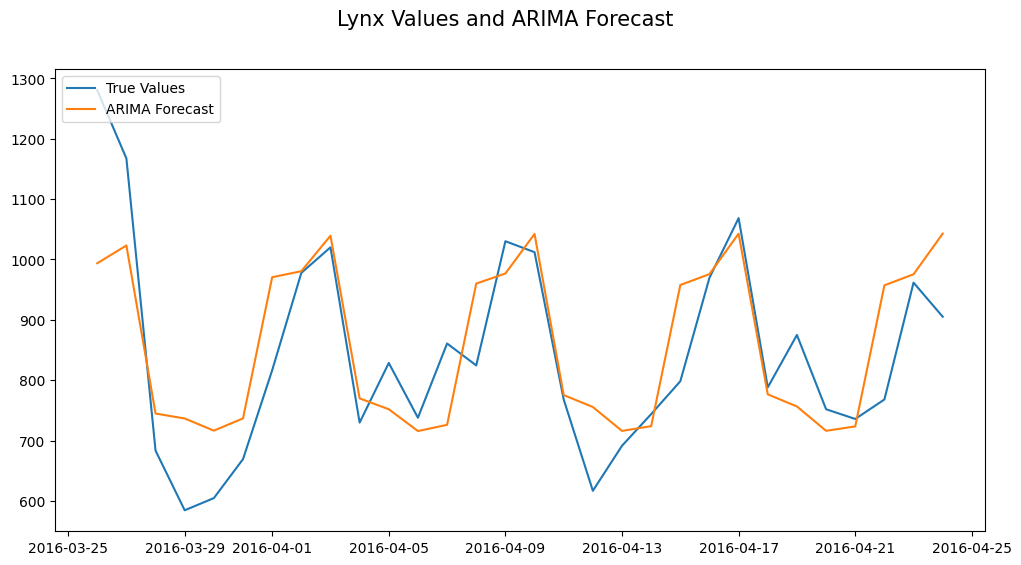

In [34]:
fig = plt.figure(figsize = (12, 6))
ax = fig.subplots()

ax.plot(ts_predict[-30:], label = "True Values")
ax.plot(y_pred_test, label = "ARIMA Forecast")

ax.legend(loc = "upper left")
fig.suptitle("Lynx Values and ARIMA Forecast", fontsize = 15)